# RNN Moneymaker

In [1]:
import csv
import re
import torch
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rows = []
with open('./data/data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    fields = next(reader)
    
    for row in reader:
        row = row[1:]
        row = [float(re.sub(' \$', '', i)) for i in row]
        rows.append(row)

raw_data = torch.tensor(rows)
print(raw_data.shape)

torch.Size([23152, 6])


In [204]:
seq_len = 100
train_val = []
for i in range(raw_data.shape[0] - seq_len - 2):
    train_val.append(rows[i:i+seq_len+1])
train_val = np.array(train_val)[:,:,:-1]
means = np.expand_dims(np.mean(train_val, axis=1), axis=1)
stds = np.expand_dims(np.std(train_val, axis=1), axis=1)
# stds[stds==0] = 1

# normalize sequences
train_val_norm = (train_val - means) / stds

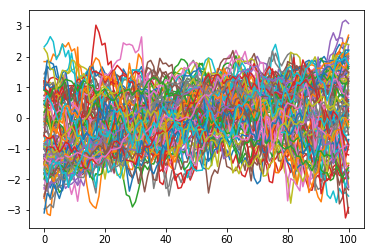

In [217]:
N, S, D = train_val_norm.shape
perm = np.random.permutation(N)
num_train = int(0.8*N)
num_val = N - num_train

train = torch.tensor(train_val_norm[perm[0:num_train],:,:]).float()
val = torch.tensor(train_val_norm[perm[num_train:],:,:]).float()

plt.plot(np.transpose(train[:100,:,0]))
plt.show()

In [218]:
X_train = train[:, :seq_len, :]
X_val = val[:, :seq_len, :]
y_train = train[:, seq_len, :]
y_val = val[:, seq_len, :]

# only want to predict Open, High, Low, Close, so delete the last column
y_train = np.delete(y_train, 4, 1)
y_val = np.delete(y_val, 4, 1)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

torch.Size([18440, 100, 5])
torch.Size([18440, 4])
torch.Size([4610, 100, 5])
torch.Size([4610, 4])


In [219]:
import torch.optim
import torch.nn as nn
import torch.nn.functional as F

In [220]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [221]:
from torch.utils.data import DataLoader

In [222]:
batch_size = 32
dataset = Dataset(X_train, y_train)
loader = DataLoader(dataset, batch_size)

In [223]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, h=None):
        if type(h) == type(None):
            out, hn = self.rnn(x)
        else:
            out, hn = self.rnn(x, h.detach())
        out = self.drop(out)
        out = self.fc(out[:, -1, :])
        return out

In [224]:
input_dim = 5
hidden_dim = 20
output_dim = 4

In [225]:
model = RNNClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [226]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []
epoch = 0

In [227]:
t0 = time.time()
num_epochs = 10
for ep in range(num_epochs):
    tstart = time.time()
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        outputs = model(data[0])
        loss = criterion(outputs, data[1])
        loss.backward()
        optimizer.step()
        if i%100==0:
            train_losses.append(loss.item())
            pXval = model(X_val)
            vloss = criterion(pXval, y_val)
            val_losses.append(vloss.item())
            print("training loss: {:<3.3f} \t val loss: {:<3.3f}".format(loss, vloss))
    
    ptrain = model(X_train)
    tloss = criterion(ptrain, y_train)
    train_losses.append(tloss.item())
    
    pXval = model(X_val)
    vloss = criterion(pXval, y_val)
    val_losses.append(vloss.item())
    epoch += 1    
    tend = time.time()
    print('epoch: {:<3d} \t time: {:<3.2f} \t training loss: {:<3.3f} \t val loss: {:<3.3f}'.format(epoch, 
            tend - tstart, tloss.item(), vloss.item()))
time_total = time.time() - t0
print('Total time: {:4.3f}, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))

training loss: 1.816 	 val loss: 1.898
training loss: 0.370 	 val loss: 0.495
training loss: 0.395 	 val loss: 0.313
training loss: 0.184 	 val loss: 0.264
training loss: 0.194 	 val loss: 0.227
training loss: 0.256 	 val loss: 0.212
epoch: 1   	 time: 33.36 	 training loss: 0.201 	 val loss: 0.201
training loss: 0.202 	 val loss: 0.195
training loss: 0.225 	 val loss: 0.187
training loss: 0.203 	 val loss: 0.191
training loss: 0.184 	 val loss: 0.185
training loss: 0.163 	 val loss: 0.179
training loss: 0.184 	 val loss: 0.172
epoch: 2   	 time: 31.95 	 training loss: 0.169 	 val loss: 0.168
training loss: 0.143 	 val loss: 0.166
training loss: 0.149 	 val loss: 0.162
training loss: 0.212 	 val loss: 0.167
training loss: 0.134 	 val loss: 0.160
training loss: 0.151 	 val loss: 0.162
training loss: 0.193 	 val loss: 0.159
epoch: 3   	 time: 31.31 	 training loss: 0.159 	 val loss: 0.153
training loss: 0.125 	 val loss: 0.153
training loss: 0.141 	 val loss: 0.162
training loss: 0.247 	

KeyboardInterrupt: 

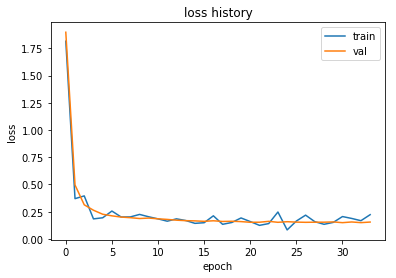

In [228]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

In [236]:
# print(y_train[0])
# plt.plot(X_train[0])
# print(X_train[0].std())

print(train[0,:seq_len,:].shape)
pred = model(train[:1, :seq_len,:])
# pred = ((model(X_train[:5]) + t_mean[:5, :, :4]) * t_std[:5, :, :4]).detach()
print(pred)

torch.Size([100, 5])
tensor([[1.5391, 1.5263, 1.5530, 1.5279]], grad_fn=<AddmmBackward>)


In [ ]:
# 